In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

In [2]:
sigma = 10
beta = 8/3
rho = 28
t_final = 100.


def lorenz(t, x):
    return [-sigma * x[0] + sigma * x[1],
            rho * x[0] - x[1] - x[0] * x[2],
            -beta * x[2] + x[0] * x[1]]


def lorenz_jacobian(t, x_fun):
    x = x_fun(t)
    return np.array([[-sigma, sigma, 0.],
                     [rho - x[2], -1, -x[0]],
                     [x[1], x[0], -beta]])


def lorenz_tangent(t, u, x_fun):
    U = u.reshape((3, 3)).T
    J = lorenz_jacobian(t, x_fun)
    return (J @ U).flatten("F")

In [3]:
sol = solve_ivp(lorenz, (0, t_final), (1, 1, 1), dense_output=True)
x_fun = sol.sol

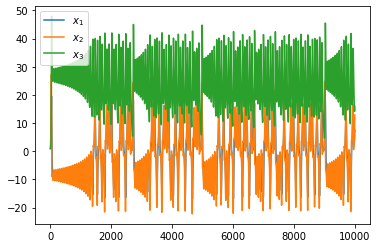

In [4]:
t_grid = np.linspace(0, t_final, num=10_000)
X = x_fun(t_grid)
xlab = [r"$x_1$", r"$x_2$", r"$x_3$"]

plt.plot(X.T)
plt.legend(xlab)
plt.show()

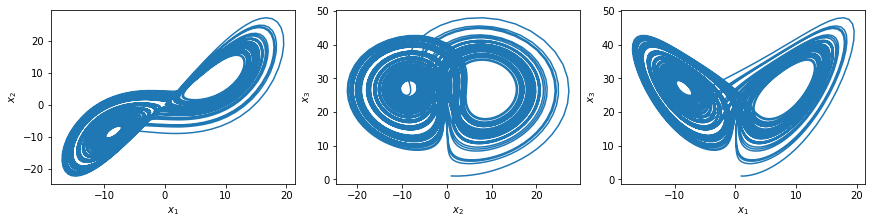

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)
axs[0].plot(X[0, :], X[1, :])
axs[0].set_xlabel(xlab[0])
axs[0].set_ylabel(xlab[1])

axs[1].plot(X[1, :], X[2, :])
axs[1].set_xlabel(xlab[1])
axs[1].set_ylabel(xlab[2])

axs[2].plot(X[0, :], X[2, :])
axs[2].set_xlabel(xlab[0])
axs[2].set_ylabel(xlab[2])

plt.show()

In [6]:
for i in range(5):
    t = np.random.uniform(0., t_final)
    U0 = np.random.rand(3, 3)
    J = lorenz_jacobian(t, x_fun)

    np.testing.assert_allclose(
        (J @ U0).flatten("F"),
        lorenz_tangent(t, U0.flatten("F"), x_fun))

In [7]:
U = solve_ivp(lorenz_tangent, 
              (0, t_final), 
              np.eye(3).flatten("F"),
              args=(x_fun, ),
              dense_output=True)

In [8]:
dt = 1e-3
t_grid = np.arange(0., t_final, dt)

I = np.eye(3)
L = np.zeros((len(t_grid), 3))
U = np.eye(3)

for i, t in enumerate(t_grid):
    # CN propagator
    J = lorenz_jacobian(t + dt, x_fun)
    U_pred =  np.linalg.solve(I - dt * J / 2, 
                              U + dt * J @ U / 2)
    Q, R = np.linalg.qr(U_pred)
    L[i, :] = np.log(np.abs(R.diagonal()))
    U = Q.copy()

[  0.88917809  -0.09195757 -14.46418813]


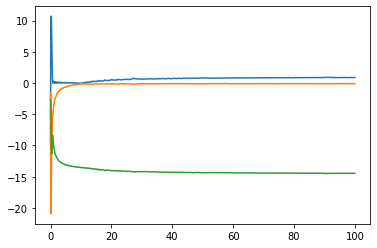

In [9]:
means = (np.cumsum(L, axis=0).T / np.arange(dt, t_final + dt, step=dt)).T
print(means[-1])
plt.plot(t_grid, means)
plt.show()